In [87]:
# load model

import glob
import os
import cv2
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from timm import create_model
import torch.nn.functional as F
from skimage import io, transform
import matplotlib.pyplot as plt

from models import Unet
# Paths
video_path = r"C:\Users\avs20\Documents\GitHub\facemap\cam1_G7c1_1_10seconds.avi"
output_video_path = "output_video_with_keypoints_224x224.mp4"
model_path = r"C:\Users\avs20\Documents\GitHub\facemap\models\best_model.pt"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [88]:
# Define model loading function
def load_model(model_path, num_output_classes=24):
    model = Unet()
    #model = create_model("vit_base_patch16_224", pretrained=False, in_chans=1, num_classes=num_output_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model



In [89]:
model = load_model(model_path=model_path)


In [90]:
# data

from torch.utils.data import DataLoader,Dataset

class facemapdataset(Dataset):
     def __init__(self, 
             data_file = 'data/facemap_softlabels.pt',
             transform=None):
          super().__init__()

          self.transform = transform
          self.data, _, self.targets = torch.load(data_file)

     def __len__(self):
          return len(self.targets)

     def __getitem__(self, index):
          image, label = self.data[index].clone(), self.targets[index].clone()
          if (self.transform is not None) and (torch.rand(1) > 0.5):
               image = image.flip([2])
               label = label.flip([2])
          return image, label

### Make dataset
dataset  = facemapdataset(transform='flip')

In [91]:
data = loader_train = DataLoader(dataset = dataset, drop_last=False,num_workers=0, pin_memory=True)

In [92]:
print(data)

In [93]:
# Initialize an empty list to accumulate all inputs
all_inputs = []

for i, (inputs, labels) in enumerate(loader_train):
    # Append each batch of inputs to the list
    all_inputs.append(inputs)

# To combine them into a single tensor if needed, concatenate along the batch dimension (dim=0)
combined_inputs = torch.cat(all_inputs, dim=0)


In [100]:
im = all_inputs[-4]
im = im.to(device)
model = model.to(device)
with torch.no_grad():  # Disable gradient calculation for inference
    scores, fmap = model(im)

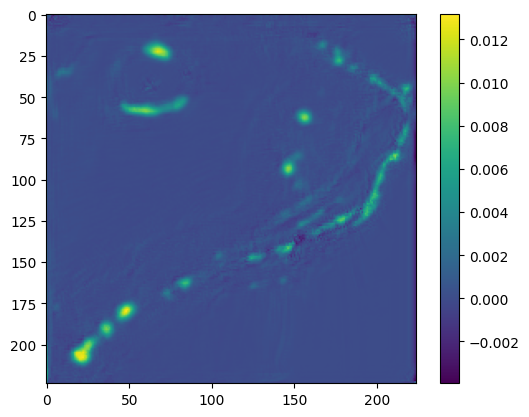

In [95]:

#print(out.shape)
# Convert the model output to a format suitable for plotting
heatmap = scores[0].detach().cpu().numpy()  # Detach and move to CPU if using a GPU

import matplotlib.pyplot as plt

im_cpu = im.cpu().numpy().squeeze()  # Squeeze to remove dimensions of size 1
#plt.imshow(im_cpu, cmap="gray")      # Use cmap="gray" for grayscale images

# Remove the extra dimension from heatmap
heatmap = heatmap.squeeze()  # Now heatmap should have shape (224, 224)

# Plotting the heatmap
plt.imshow(heatmap, cmap='viridis')  # Optionally, choose a colormap like 'viridis' for better visualization
plt.colorbar()  # Add a color bar to visualize the scale
plt.show()

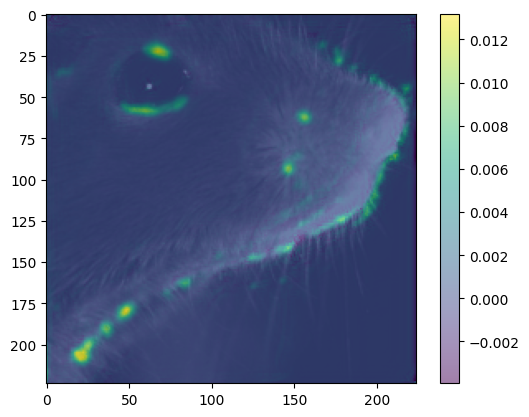

In [96]:
# Initialize figure and plot the image
fig, ax = plt.subplots()
ax.imshow(im_cpu, cmap="gray")  # Use grayscale for original image

# Overlay heatmap on the image
ax.imshow(heatmap, cmap='viridis', alpha=0.5)  # Use alpha for transparency
plt.colorbar(ax.imshow(heatmap, cmap='viridis', alpha=0.5))  # Add color bar for heatmap

In [97]:
# fmaps (attention maps aka feature maps)

#fmap = fmap.cpu().numpy()
#print(fmap)

#fmap = fmap.squeeze().cpu().numpy()



In [98]:
#print(fmap[1].shape)

(224, 224)


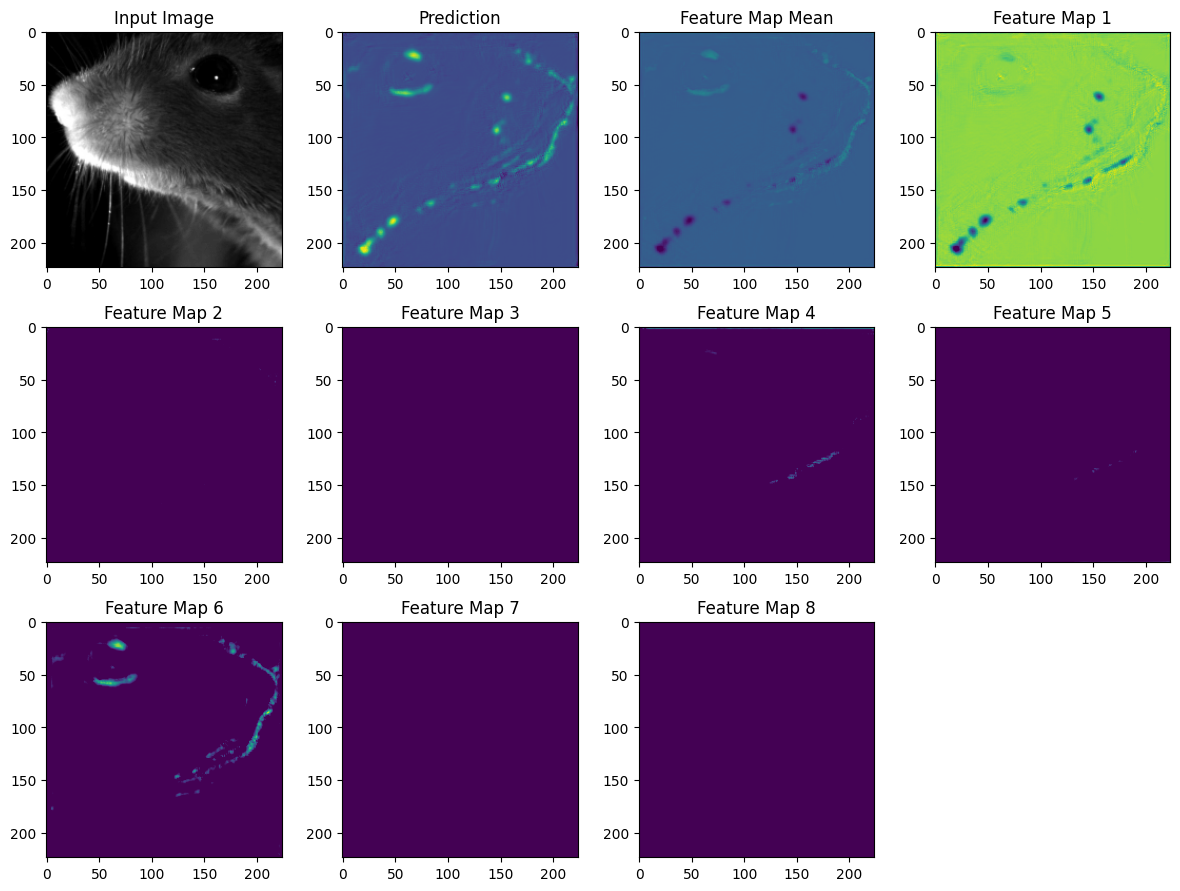

In [101]:
import matplotlib.pyplot as plt

# Prepare data for plotting
pred = scores.squeeze().detach().cpu().numpy()
img = inputs.squeeze().detach().cpu().numpy()
fmap_mean = fmap.mean(1).squeeze().cpu().numpy()
fmap_each = fmap.squeeze().cpu().numpy()

# Individual feature maps
fmap_1 = fmap_each[0]
fmap_2 = fmap_each[1]
fmap_3 = fmap_each[2]
fmap_4 = fmap_each[3]
fmap_5 = fmap_each[4]
fmap_6 = fmap_each[5]
fmap_7 = fmap_each[6]
fmap_8 = fmap_each[7]

# Plotting using a 3x4 grid
plt.figure(figsize=(12, 9))

# Display the main images
plt.subplot(3, 4, 1)
plt.imshow(img, cmap='gray')
plt.title("Input Image")

plt.subplot(3, 4, 2)
plt.imshow(pred)
plt.title("Prediction")

plt.subplot(3, 4, 3)
plt.imshow(fmap_mean)
plt.title("Feature Map Mean")

# Display each individual feature map
plt.subplot(3, 4, 4)
plt.imshow(fmap_1)
plt.title("Feature Map 1")

plt.subplot(3, 4, 5)
plt.imshow(fmap_2)
plt.title("Feature Map 2")

plt.subplot(3, 4, 6)
plt.imshow(fmap_3)
plt.title("Feature Map 3")

plt.subplot(3, 4, 7)
plt.imshow(fmap_4)
plt.title("Feature Map 4")

plt.subplot(3, 4, 8)
plt.imshow(fmap_5)
plt.title("Feature Map 5")

plt.subplot(3, 4, 9)
plt.imshow(fmap_6)
plt.title("Feature Map 6")

plt.subplot(3, 4, 10)
plt.imshow(fmap_7)
plt.title("Feature Map 7")

plt.subplot(3, 4, 11)
plt.imshow(fmap_8)
plt.title("Feature Map 8")

plt.tight_layout()
plt.show()


#Movie

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Initialize an empty list to accumulate frames
frames = []

# Iterate over all images in combined_inputs
for im in combined_inputs:
    # Move the image to the device for processing
    im = im.to(device)

    # Forward pass through the model to get scores and feature map
    with torch.no_grad():  # Disable gradient calculation for inference
        scores, fmap = model(im.unsqueeze(0))  # Add batch dimension

    # Convert scores to a heatmap and remove any extra dimension
    heatmap = scores[0].detach().cpu().numpy().squeeze()  # Now heatmap has shape (224, 224)

    # Move image to CPU and convert to numpy for plotting
    im_cpu = im.cpu().numpy().squeeze()  # Squeeze to remove dimensions of size 1

    # Initialize figure and plot the image
    fig, ax = plt.subplots()
    ax.imshow(im_cpu, cmap="gray")  # Use grayscale for original image

    # Overlay heatmap on the image
    ax.imshow(heatmap, cmap='viridis', alpha=0.5)  # Use alpha for transparency
    plt.colorbar(ax.imshow(heatmap, cmap='viridis', alpha=0.5))  # Add color bar for heatmap

    # Append the current figure as a frame in the frames list
    frames.append([ax.imshow(heatmap, cmap='viridis', alpha=0.5)])

# Create an animation from the frames
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True)

# Save the animation as a movie file
ani.save('heatmap_movie.mp4', writer='ffmpeg', fps=5)  # Adjust fps as needed
plt.close()


In [25]:
import torch
import matplotlib.pyplot as plt

# Assume combined_inputs is defined and contains your images
# Assume device is defined and set to either 'cuda' or 'cpu'
# Assume model is defined and loaded

# Iterate over all images in combined_inputs
for idx, im in enumerate(combined_inputs):  # Get index and image
    # Move the image to the device for processing
    im = im.to(device)

    # Forward pass through the model to get scores and feature map
    with torch.no_grad():  # Disable gradient calculation for inference
        scores, fmap = model(im.unsqueeze(0))  # Add batch dimension

    # Convert scores to a heatmap and remove any extra dimension
    heatmap = scores[0].detach().cpu().numpy().squeeze()  # Now heatmap has shape (224, 224)

    # Move image to CPU and convert to numpy for plotting
    im_cpu = im.cpu().numpy().squeeze()  # Squeeze to remove dimensions of size 1

    # Initialize figure and plot the image
    fig, ax = plt.subplots(figsize=(8, 8))  # You can adjust the figure size

    # Display the original image in grayscale
    ax.imshow(im_cpu, cmap="gray", interpolation='nearest')

    # Overlay heatmap on the image with transparency
    heatmap_overlay = ax.imshow(heatmap, cmap='viridis', alpha=0.5, interpolation='nearest')

    # Add color bar for the heatmap
    #plt.colorbar(heatmap_overlay, ax=ax, fraction=0.046, pad=0.04)

    # Optional: Add titles or labels if necessary
    #ax.set_title(f'Frame {idx}')  # Title with the current frame number
    ax.axis('off')  # Hide axes if you want a cleaner look

    # Save the combined image to a file with a unique filename
    plt.savefig(f'combined_image_{idx}.png', bbox_inches='tight', dpi=300)  # Save with frame number
    plt.close(fig)  # Close the figure to free up memory


In [22]:
import os
import torch
import matplotlib.pyplot as plt

# Assume combined_inputs is defined and contains your images
# Assume device is defined and set to either 'cuda' or 'cpu'
# Assume model is defined and loaded

# Define the directory to save the images
save_directory = 'combined_images'  # Change this to your desired folder name

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Iterate over all images in combined_inputs
for idx, im in enumerate(combined_inputs):  # Get index and image
    # Move the image to the device for processing
    im = im.to(device)

    # Forward pass through the model to get scores and feature map
    with torch.no_grad():  # Disable gradient calculation for inference
        scores, fmap = model(im.unsqueeze(0))  # Add batch dimension

    # Convert scores to a heatmap and remove any extra dimension
    heatmap = scores[0].detach().cpu().numpy().squeeze()  # Now heatmap has shape (224, 224)

    # Move image to CPU and convert to numpy for plotting
    im_cpu = im.cpu().numpy().squeeze()  # Squeeze to remove dimensions of size 1

    # Initialize figure and plot the image
    fig, ax = plt.subplots(figsize=(8, 8))  # You can adjust the figure size

    # Display the original image in grayscale
    ax.imshow(im_cpu, cmap="gray", interpolation='nearest')

    # Overlay heatmap on the image with transparency
    heatmap_overlay = ax.imshow(heatmap, cmap='viridis', alpha=0.5, interpolation='nearest')

    # Add color bar for the heatmap
    plt.colorbar(heatmap_overlay, ax=ax, fraction=0.046, pad=0.04)

    # Optional: Add titles or labels if necessary
    ax.set_title(f'Frame {idx}')  # Title with the current frame number
    ax.axis('off')  # Hide axes if you want a cleaner look

    # Save the combined image to a file in the specified directory
    plt.savefig(os.path.join(save_directory, f'combined_image_{idx}.png'), bbox_inches='tight', dpi=300)  # Save with frame number
    plt.close(fig)  # Close the figure to free up memory


In [ ]:
# Create an animation from the frames
ani = animation.ArtistAnimation(fig, frames, interval=200, blit=True)

# Save the animation as a movie file
ani.save('heatmap_movie.mp4', writer='ffmpeg', fps=5)  # Adjust fps as needed